### Time Resolved Photoluminescence Modeling

In a TRPL experiment the sample is hitted by a laser pulse of a very short time (picoseconds) which generates a first excess carrier density *n(0)*. This value decays in time due to charge recombination processes happening in the material.
The overall decay of the excess carrier density results in a exponential decay curve that is normally fitted with a multiple exponential. But the main limitation is that lifetime constants are extrapoleted by these fitting curve which do not explain precisely the physical processes which play simultaneously a role in the decay dynamics. 

For these reasons, we want to analyze in details the processes of generation and recombination of charges that happen after excitation to find the best and most precise way to get information on carrier recombination processes.

We start from the continuity equation which describe the number of photogenerated excess carrier in time:

$\frac{\delta(n)}{\delta(t)} = - R_1(z,t) - R_2(z,t)$

* $R_1$ is the recombination constant associated with Shockley Read Hall (SRH) recombination

$R_1 = \frac{(n_0 + n)(p_0 + p) - n_i^2}{(n_0 + n) + (p_0 + p) + 2n_icosh\frac{(E_i - E_t)}{kT}} \sigma \nu_{th} N_t$

* $R_2$ is the recombination rate associated with the band-to-band recombination (bimolecular process)


LLI
$R_2(z, t) = k_2[p(p_0)]$

HLI
$R_2(z, t) = k_2[p^2]$

The Auger recombination is negligible under the normal working condition of solar cells (below an excess carrier density of $10^{17} cm^{−3}$ )

* **Low Level Injection regime: $n=p<<p_0$**

Under low injection level (LLI) conditions, the photocarrier
density *n* is much lower than the equilibrium density of the
majority carriers; $R_1$ can be expressed as a linear function of the
photocarrier density *n(z,t)*. 
Approximation:

$R_1 = k_1n(z,t)$

Where $k_1$ is the SRH recombination frequency(?=constant?)

Approximation of $R_2$:

$R_2 = k_2p_0p$

**Continuity equation at LLI**

$\frac{\delta(n)}{\delta(t)} = -(k_1 + k_2p_0)p$

$k_2p_0$ is non-negligible only if the
absorbing layer is highly doped 
($k1 = 10^7 s^{−1}$ and $k_2 = 10^{−10} \frac{cm^3}{s}, p_0 > 10^{17} cm^{−3}$). 
Therefore, under LLI conditions and low doping concentration, the decay of the photogenerated carriers is mainly controlled by the SRH recombination rate $k_1$

**Continuity equation at HLI**

$\frac{\delta(n)}{\delta(t)} = -(k'_1 + k_2p_0)p - k_2p^2$  

where $k'_1$ 

Approximation of the existance of only deep level traps:

**LLI** : $\frac{\delta(n)}{\delta(t)} = -(k_1 + k_2p_0)p - k_2p^2$ 

**HLI** : $\frac{\delta(n)}{\delta(t)} = -(\frac{k_1}{2} + k_2p_0)p - k_2p^2$ 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import skewnorm
from scipy.stats import exponnorm
from customplotting.general import plot_xy, save_fig
from functions import *
from scipy.stats import norm

In [2]:
"""Recycle params for plotting"""
plt.rc('xtick', labelsize = 30)
plt.rc('xtick.major', pad = 3)
plt.rc('ytick', labelsize = 30)
plt.rc('lines', lw = 3.5, markersize = 20.5)
plt.rc('legend', fontsize = 30)
plt.rc('axes', linewidth = 3.5)

## High level injection regime equation

In [4]:
# HLI continuity equation: dn/dt with k2, n0 as a constant and k1 as a variable
def photoluminescence_HLI(t, k1):
    def model(n, t):
        k2 = 2e-10
        dndt = -(k2*(n**2) + k1*n)
        return dndt
    n0 = np.tile(np.power(10, 17), 50)
    n = odeint(model, n0, t)
    k2 = 2e-10
    pl_HLI = k2 * (n**2)
    return pl_HLI

## Low level injection regime equation

In [5]:
# LLI continuity equation: dn/dt with k2, n0 as a constant and k1 as a variable
def photoluminescence_LLI(t, k1):
    def model(n, t):
        k2 = 2e-10
        dndt = -(k2*(n**2) + k1*n)
        return dndt
    n0 = np.tile(np.power(10, 14), 50)
    n = odeint(model, n0, t)
    k2 = 2e-10
    p0 = 1e15
    pl_LLI = k2 * n* p0
    return pl_LLI

## 1) Simulation of PL decays in HLI with a *linear distribution* of K_nonrad from 10^5 to 10^7 cm-3 

In [19]:
# photoluminescence database from k1 from 1e5 to 1e7 and time from 0 to 1000ns
pl_HLI = photoluminescence_HLI(t = np.linspace(0,5000, 5000)*1e-9, k1= np.logspace(5, 7, 50))
pl_HLI

array([[2.00000000e+24, 2.00000000e+24, 2.00000000e+24, ...,
        2.00000000e+24, 2.00000000e+24, 2.00000000e+24],
       [1.92194177e+24, 1.92190426e+24, 1.92186305e+24, ...,
        1.89102694e+24, 1.88797066e+24, 1.88461889e+24],
       [1.84835858e+24, 1.84828711e+24, 1.84820860e+24, ...,
        1.78992246e+24, 1.78419542e+24, 1.77792501e+24],
       ...,
       [1.15964216e+20, 1.09856504e+20, 1.03468671e+20, ...,
        1.82603007e-13, 5.93733233e-17, 8.60427606e-21],
       [1.15905710e+20, 1.09799807e+20, 1.03413937e+20, ...,
        1.79601097e-13, 5.83019428e-17, 8.43386622e-21],
       [1.15847242e+20, 1.09743149e+20, 1.03359239e+20, ...,
        1.76648537e-13, 5.72498951e-17, 8.26683140e-21]])

In [20]:
pl_HLI.shape

(5000, 50)

In [21]:
#x values of time
t = np.linspace(0,5000, 5000)*1e-9
t

array([0.00000000e+00, 1.00020004e-09, 2.00040008e-09, ...,
       4.99799960e-06, 4.99899980e-06, 5.00000000e-06])

In [23]:
#weighted sum of photoluminescence data
pl_HLI_sum = pl_HLI.sum(axis=0)
pl_HLI_sum.size

50

In [25]:
#weighted average og the photoluminescence data
pl_HLI_avg = np.average(pl_HLI, weights=pl_HLI_sum, axis=-1)
pl_HLI_avg.size

5000

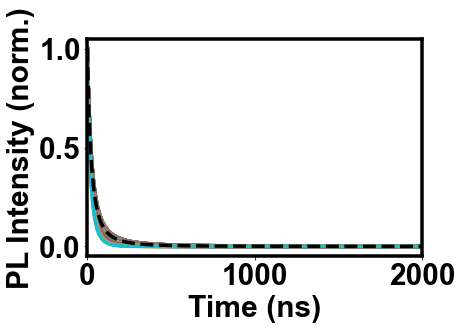

In [26]:
#plot of exponential decay of photoluminescence
plt.plot(t*1e9, pl_HLI/np.max(pl_HLI))
plt.plot(t*1e9, pl_HLI_avg/np.max(pl_HLI_avg),'k--', label="Average")
plt.xlabel('Time (ns)', fontsize=30, fontweight='bold')
plt.ylabel('PL Intensity (norm.)', fontsize= 30, fontweight='bold')
plt.xlim(0, 2000)
plt.show()

In [28]:
#streched exponential fitting of the average PL exponential decay
stretched_exp = stretch_exp_fit(pl_HLI_avg/np.max(pl_HLI_avg), t)
print("tau_c (ns) = "+str(stretched_exp[0]*1e9))
print("Beta = "+str(stretched_exp[1]))
print("avg. tau (ns) = "+str(stretched_exp[3]*1e9))

tau_c (ns) = 9.782790364179203
Beta = 0.4290895700021653
avg. tau (ns) = 27.09815720110916


In [30]:
#double exponential fitting of the average PL exponential decay
double_exp = double_exp_fit(pl_HLI_avg/np.max(pl_HLI_avg), t)
print("tau1 (ns) = "+str(double_exp[0]*1e9))
print("a1 = "+str(double_exp[1]))
print("tau2 (ns) = "+str(double_exp[2]*1e9))
print("a2 = "+str(double_exp[3]))
print("avg. tau (ns) = "+str(double_exp[4]*1e9))

tau1 (ns) = 46.45823257874929
a1 = 0.7498877723820346
tau2 (ns) = 489.3390165579311
a2 = 0.015937265133108502
avg. tau (ns) = 55.67483967681064


In [36]:
#triple exponential fitting of the average PL exponential decay
#triple_exp = triple_exp_fit(pl_HLI_avg/np.max(pl_HLI_avg), t)
#print("tau1 (ns) = "+str(triple_exp[0]*1e9))
#print("a1 = "+str(triple_exp[1]))
#print("tau2 (ns) = "+str(triple_exp[2]*1e9))
#print("a2 = "+str(triple_exp[3]))
#print("tau3 (ns) = "+str(triple_exp[4]*1e9))
#print("a3 (ns) = "+str(triple_exp[5]))
#print("avg. tau (ns) = "+str(triple_exp[6]*1e9))

In [38]:
#single exponential fitting of the average PL exponential decay
single_exp = single_exp_fit(pl_HLI_avg/np.max(pl_HLI_avg), t)
print("tau (ns) = "+str(single_exp[0]*1e9))
print("a = "+str(single_exp[1]))
print("avg. tau (ns) = "+str(single_exp[2]*1e9))

tau (ns) = 302.707397518923
a = 0.24105242832815726
avg. tau (ns) = 302.707397518923


(1e-06, 1)

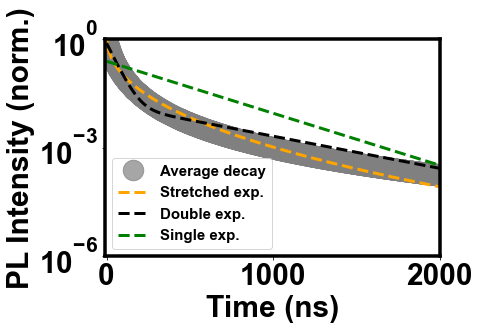

In [39]:
# plot fitting functions of the average PL exponential decay
#plt.figure(figsize=(10,8))
plt.plot(t*1e9, pl_HLI_avg/np.max(pl_HLI_avg),'C1o',color= 'grey', alpha=0.7,label="Average decay")
plt.plot(t*1e9, stretched_exp[4], '--',color='orange', lw = 3, label="Stretched exp.")
plt.plot(t*1e9, double_exp[5], 'k--', lw = 3, label="Double exp.")
#plt.plot(t*1e9, triple_exp[7], 'c--', lw = 3, label="triple exp fit")
plt.plot(t*1e9, single_exp[3], 'g--', lw = 3, label="Single exp.")
plt.yscale('log')
plt.xlabel("Time (ns)", fontsize=30, fontweight ='bold')
plt.ylabel("PL Intensity (norm.)", fontsize=30, fontweight ='bold')
plt.legend(fontsize=15)
plt.xlim(-10, 2000)
plt.ylim(0.000001, 1)




### Calculation of theoretical tau  
$I = I_0e^{(\frac{-t}{\tau})}$ when t = $\tau$ and $I = \frac{I_0}{e}$

In [40]:
PL_e_HLI = np.max(pl_HLI, axis=0)/np.e
PL_e_HLI.size

50

In [41]:
#function to calulate the index of the PL/e values in the "pl" database by looking at the nearest neighbor of the "PL_e_values" inside "pl"
def find_idx(array, value):
    return (np.abs(array - value)).argmin()

In [42]:
# index of PL data calculated considering each array inside the array of pl singularly
time_PL_HLI = np.array([])
for ix, i in enumerate(PL_e_HLI):
    b = find_idx(pl_HLI[:, ix], i)
    time_PL_HLI = np.append(time_PL_HLI, b)
time_PL_HLI

array([32., 32., 32., 32., 32., 32., 32., 32., 32., 32., 32., 32., 32.,
       32., 32., 32., 31., 31., 31., 31., 31., 31., 31., 31., 31., 30.,
       30., 30., 30., 29., 29., 29., 29., 28., 28., 28., 27., 27., 26.,
       26., 25., 25., 24., 24., 23., 22., 22., 21., 20., 20.])

In [43]:
# array of lifetime at which PL=PL0/e
lifetime_HLI = np.array([])
for i in time_PL_HLI:
    lifetime_HLI = np.append(lifetime_HLI, t[int(i)]) 
lifetime_HLI*1e9

array([32.00640128, 32.00640128, 32.00640128, 32.00640128, 32.00640128,
       32.00640128, 32.00640128, 32.00640128, 32.00640128, 32.00640128,
       32.00640128, 32.00640128, 32.00640128, 32.00640128, 32.00640128,
       32.00640128, 31.00620124, 31.00620124, 31.00620124, 31.00620124,
       31.00620124, 31.00620124, 31.00620124, 31.00620124, 31.00620124,
       30.0060012 , 30.0060012 , 30.0060012 , 30.0060012 , 29.00580116,
       29.00580116, 29.00580116, 29.00580116, 28.00560112, 28.00560112,
       28.00560112, 27.00540108, 27.00540108, 26.00520104, 26.00520104,
       25.005001  , 25.005001  , 24.00480096, 24.00480096, 23.00460092,
       22.00440088, 22.00440088, 21.00420084, 20.0040008 , 20.0040008 ])

In [44]:
avg_lifetime_HLI = np.average(lifetime_HLI, weights=pl_HLI_sum, axis=-1)
avg_lifetime_HLI*1e9

29.557889310916483

(0.0, 600.0)

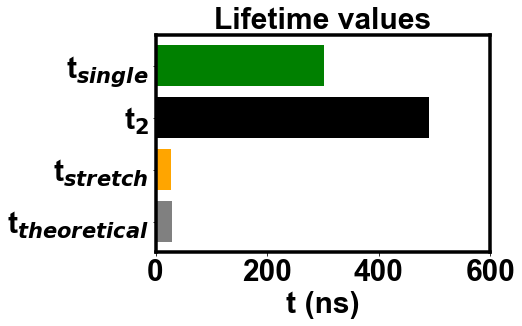

In [46]:
#plot of different tau values, from mathematical calculation (reference) and fitting functions
plt.figure()
plt.title("Lifetime values", fontsize=30, fontweight="bold")
plt.barh("t$_{theoretical}$", avg_lifetime_HLI*1e9, color='grey')
plt.barh("t$_{stretch}$", stretched_exp[3]*1e9, color = 'orange')
#plt.barh("t$_{avg}$", double_exp[4]*1e9, color= 'red')
plt.barh("t$_{2}$", double_exp[2]*1e9, color='black')
plt.barh("t$_{single}$", single_exp[2]*1e9, color= 'green')
plt.xlabel("t (ns)", fontsize =30 , fontweight='bold')
plt.xlim(0, 600)
#plt.barh("Triple Exp $\tau^{3}$", triple_exp[4]*1e9)
#plt.barh("Triple Exp $\tau^{avg}$", triple_exp[6]*1e9)

In [47]:
surf_lifetime_avg = calculate_surface_lifetime(avg_lifetime_HLI*1e9)
SRV_avg = calculate_srv (surf_lifetime_avg)
print("SRV1=0 theoretical value = " +str(SRV_avg[0]) +' cm/s')
print("SRV1=SRV2 theoretical value = " +str(SRV_avg[1]) +' cm/s' )

surf_lifetime_stretch = calculate_surface_lifetime(stretched_exp[3]*1e9)
SRV_avg_stretch = calculate_srv (surf_lifetime_stretch)
print("SRV1=0 from stretched exp fitting = " +str(SRV_avg_stretch[0]) +' cm/s')
print("SRV1=SRV2 from stretched exp fitting = " +str(SRV_avg_stretch[1]) +' cm/s' )

surf_lifetime_tau_2 = calculate_surface_lifetime(double_exp[2]*1e9)
SRV_avg_tau2 = calculate_srv (surf_lifetime_tau_2)
print("SRV1=0 from tau 2 of biexp fitting = " +str(SRV_avg_tau2[0]) +' cm/s')
print("SRV1=SRV2 from tau 2 of biexp fitting = " +str(SRV_avg_tau2[1]) +' cm/s' )

surf_lifetime_bi = calculate_surface_lifetime(double_exp[4]*1e9)
SRV_avg_bi = calculate_srv (surf_lifetime_bi)
print("SRV1=0 from tau avg biexp fitting = " +str(SRV_avg_bi[0]) +' cm/s')
print("SRV1=SRV2 from tau avg biexp fitting = " +str(SRV_avg_bi[1]) +' cm/s' )

surf_lifetime_mono = calculate_surface_lifetime(single_exp[2]*1e9)
SRV_avg_mono = calculate_srv (surf_lifetime_mono)
print("SRV1=0 from tau avg mono exp. fitting = " +str(SRV_avg_mono[0]) +' cm/s')
print("SRV1=SRV2 from tau avg mono exp. fitting = " +str(SRV_avg_mono[1]) +' cm/s' )

SRV1=0 theoretical value = 1381.8359257769614 cm/s
SRV1=SRV2 theoretical value = 678.2563411921157 cm/s
SRV1=0 from stretched exp fitting = 1511.158865038487 cm/s
SRV1=SRV2 from stretched exp fitting = 740.4628919709656 cm/s
SRV1=0 from tau 2 of biexp fitting = 76.84915177262005 cm/s
SRV1=SRV2 from tau 2 of biexp fitting = 38.38472513582621 cm/s
SRV1=0 from tau avg biexp fitting = 722.7455825941486 cm/s
SRV1=SRV2 from tau avg biexp fitting = 357.8784925178958 cm/s
SRV1=0 from tau avg mono exp. fitting = 127.43264672991397 cm/s
SRV1=SRV2 from tau avg mono exp. fitting = 63.60682102863423 cm/s


Text(0.5, 0, '$SRV (cm/s)$')

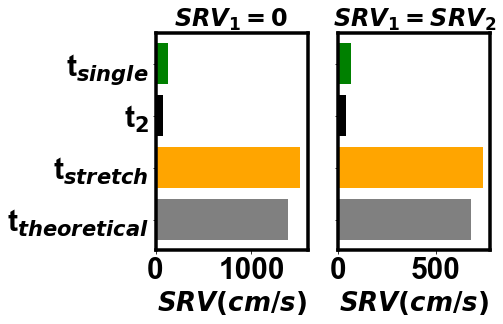

In [48]:

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.barh("t$_{theoretical}$", SRV_avg[0], color='grey')
ax1.barh("t$_{stretch}$", SRV_avg_stretch[0], color='orange')
#ax1.barh("t$_{avg}$", SRV_avg_bi[0])
ax1.barh("t$_{2}$", SRV_avg_tau2[0], color='black')
ax1.barh("t$_{single}$", SRV_avg_mono[0], color='green')
ax1.set_title("$SRV_{1} = 0$")
ax1.set_xlabel("$SRV (cm/s)$", fontsize= 26)

ax2.barh("t$_{theoretical}$",SRV_avg[1], color='grey')
ax2.barh("t$_{stretch}$", SRV_avg_stretch[1], color='orange')
#ax2.barh("t$_{avg}$", SRV_avg_bi[1])
ax2.barh("t$_{2}$",SRV_avg_tau2[1], color='black')
ax2.barh("t$_{single}$", SRV_avg_mono[1], color='green')
ax2.set_title("$SRV_{1} = SRV_{2}$")
ax2.set_xlabel("$SRV (cm/s)$", fontsize=26)

## 2) Simulation of PL decays in LLI with a *linear distribution* of K_nonrad from 10^5 to 10^7 cm-3 

In [49]:
#creation of LLI PL decay curves and average decay curve

# photoluminescence database from k1 from 1e5 to 1e7 and time from 0 to 1000ns
pl_LLI = photoluminescence_LLI(t = np.linspace(0,5000, 5000)*1e-9, k1= np.logspace(5, 7, 50))
pl_LLI

#weighted sum of photoluminescence data
pl_LLI_sum = pl_LLI.sum(axis=0)
pl_LLI_sum

#weighted average og the photoluminescence data
pl_LLI_avg = np.average(pl_LLI, weights=pl_LLI_sum, axis=-1)
pl_LLI_avg

array([2.00000000e+19, 1.99873956e+19, 1.99748226e+19, ...,
       5.16709913e+18, 5.16609029e+18, 5.16508172e+18])

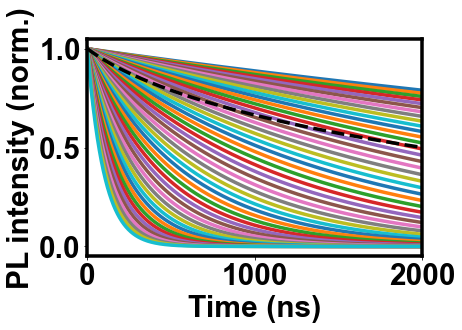

In [50]:
#plot of exponential decay of photoluminescence
plt.plot(t*1e9, pl_LLI/np.max(pl_LLI))
plt.plot(t*1e9, pl_LLI_avg/np.max(pl_LLI_avg),'k--', label="Average")
plt.xlabel('Time (ns)', fontsize =30, fontweight ='bold')
plt.ylabel('PL intensity (norm.)', fontsize= 30, fontweight ='bold')
plt.xlim(0, 2000)
plt.show()

In [53]:
#streched exponential fitting of the average PL exponential decay
stretched_exp = stretch_exp_fit(pl_LLI_avg/np.max(pl_LLI_avg), t)
print("tau_c (ns) = "+str(stretched_exp[0]*1e9))
print("Beta = "+str(stretched_exp[1]))
print("avg. tau (ns) = "+str(stretched_exp[3]*1e9))

tau_c (ns) = 3184.4904845671135
Beta = 0.7188647800130887
avg. tau (ns) = 3932.7923633425758


In [55]:
#double exponential fitting of the average PL exponential decay
double_exp = double_exp_fit(pl_LLI_avg/np.max(pl_LLI_avg), t)
print("tau1 (ns) = "+str(double_exp[0]*1e9))
print("a1 = "+str(double_exp[1]))
print("tau2 (ns) = "+str(double_exp[2]*1e9))
print("a2 = "+str(double_exp[3]))
print("avg. tau (ns) = "+str(double_exp[4]*1e9))

tau1 (ns) = 809.1654241562322
a1 = 0.2622888979890825
tau2 (ns) = 4806.135612295808
a2 = 0.7236275461720992
avg. tau (ns) = 3742.7991478814315


In [56]:
#triple exponential fitting of the average PL exponential decay
#triple_exp = triple_exp_fit(pl_LLI_avg/np.max(pl_LLI_avg), t)
#print("tau1 (ns) = "+str(triple_exp[0]*1e9))
#print("a1 = "+str(triple_exp[1]))
#print("tau2 (ns) = "+str(triple_exp[2]*1e9))
#print("a2 = "+str(triple_exp[3]))
#print("tau3 (ns) = "+str(triple_exp[4]*1e9))
#print("a3 (ns) = "+str(triple_exp[5]))
#print("avg. tau (ns) = "+str(triple_exp[6]*1e9))

In [58]:
#single exponential fitting of the average PL exponential decay
single_exp = single_exp_fit(pl_LLI_avg/np.max(pl_LLI_avg), t)
print("tau (ns) = "+str(single_exp[0]*1e9))
print("a = "+str(single_exp[1]))
print("avg. tau (ns) = "+str(single_exp[2]*1e9))

tau (ns) = 3777.0056273050627
a = 0.8886981683106621
avg. tau (ns) = 3777.0056273050627


(0.5, 1)

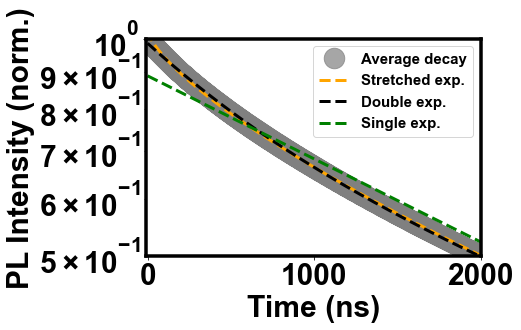

In [61]:
# plot fitting functions of the average PL exponential decay
#plt.figure(figsize=(10,8))
plt.plot(t*1e9, pl_LLI_avg/np.max(pl_LLI_avg),'C1o',color= 'grey', alpha=0.7,label="Average decay")
plt.plot(t*1e9, stretched_exp[4], '--',color='orange', lw = 3, label="Stretched exp.")
plt.plot(t*1e9, double_exp[5], 'k--', lw = 3, label="Double exp.")
#plt.plot(t*1e9, triple_exp[7], 'c--', lw = 3, label="triple exp fit")
plt.plot(t*1e9, single_exp[3], 'g--', lw = 3, label="Single exp.")
plt.yscale('log')
plt.xlabel("Time (ns)", fontsize=30, fontweight ='bold')
plt.ylabel("PL Intensity (norm.)", fontsize=30, fontweight ='bold')
plt.legend(fontsize=15)
plt.xlim(-10, 2000)
plt.ylim(0.5, 1)

In [62]:
#Mathematical derivation of theoretical average lifetime from weighted average of each time at which I = I0/e

#photoluminescence maximum from LLI regime divided by e
PL_e_LLI = np.max(pl_LLI, axis=0)/np.e
PL_e_LLI.size

# index of LLI PL data calculated considering each array inside the array of pl singularly
time_PL_LLI = np.array([])
for ix, i in enumerate(PL_e_LLI):
    b = find_idx(pl_LLI[:, ix], i)
    time_PL_LLI = np.append(time_PL_LLI, b)
time_PL_LLI

# array of lifetime at which PL=PL0/e at LLI
lifetime_LLI = np.array([])
for i in time_PL_LLI:
    lifetime_LLI = np.append(lifetime_LLI, t[int(i)]) 
lifetime_LLI*1e9

#weighted average of calculate lifetimes with pl_sum weights
avg_lifetime_LLI = np.average(lifetime_LLI, weights=pl_LLI_sum, axis=-1)
avg_lifetime_LLI*1e9

3301.6673118747444

Text(0.5, 0, 't (ns)')

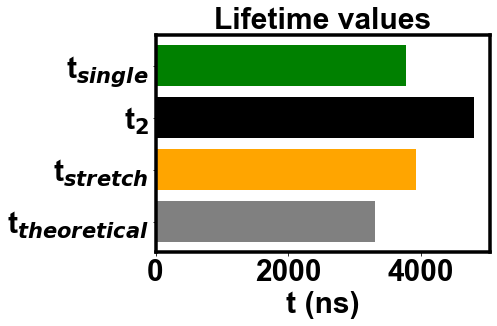

In [63]:

#plot of different tau values, from mathematical calculation (reference) and fitting functions
plt.figure()
plt.title("Lifetime values", fontsize=30, fontweight="bold")
plt.barh("t$_{theoretical}$", avg_lifetime_LLI*1e9, color='grey')
plt.barh("t$_{stretch}$", stretched_exp[3]*1e9, color = 'orange')
#plt.barh("t$_{avg}$", double_exp[4]*1e9, color= 'red')
plt.barh("t$_{2}$", double_exp[2]*1e9, color='black')
plt.barh("t$_{single}$", single_exp[2]*1e9, color= 'green')
plt.xlabel("t (ns)", fontsize =30 , fontweight='bold')
#plt.xlim(0, 1000)
#plt.barh("Triple Exp $\tau^{3}$", triple_exp[4]*1e9)
#plt.barh("Triple Exp $\tau^{avg}$", triple_exp[6]*1e9)

SRV1=0 theoretical value = 7.11600301855434 cm/s
SRV1=SRV2 theoretical value = 3.5576594987337797 cm/s
SRV1=0 from stretched exp fitting = 5.171372045383631 cm/s
SRV1=SRV2 from stretched exp fitting = 2.585505392550129 cm/s
SRV1=0 from tau 2 of biexp fitting = 3.322893704383589 cm/s
SRV1=SRV2 from tau 2 of biexp fitting = 1.6613722721885233 cm/s
SRV1=0 from tau avg biexp fitting = 5.6877711600814855 cm/s
SRV1=SRV2 from tau avg biexp fitting = 2.8436670758072684 cm/s
SRV1=0 from tau avg biexp fitting = 5.590962893778656 cm/s
SRV1=SRV2 from tau avg biexp fitting = 2.7952703171488147 cm/s


Text(0.5, 0, '$SRV (cm/s)$')

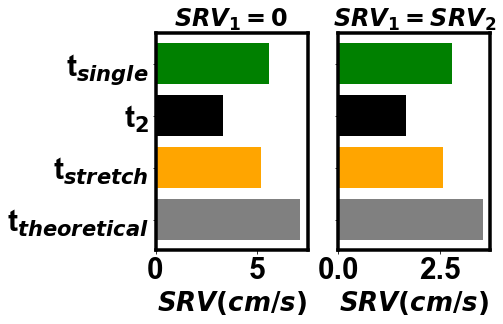

In [64]:


surf_lifetime_avg = calculate_surface_lifetime(avg_lifetime_LLI*1e9)
SRV_avg = calculate_srv (surf_lifetime_avg)
print("SRV1=0 theoretical value = " +str(SRV_avg[0]) +' cm/s')
print("SRV1=SRV2 theoretical value = " +str(SRV_avg[1]) +' cm/s' )

surf_lifetime_stretch = calculate_surface_lifetime(stretched_exp[3]*1e9)
SRV_avg_stretch = calculate_srv (surf_lifetime_stretch)
print("SRV1=0 from stretched exp fitting = " +str(SRV_avg_stretch[0]) +' cm/s')
print("SRV1=SRV2 from stretched exp fitting = " +str(SRV_avg_stretch[1]) +' cm/s' )

surf_lifetime_tau_2 = calculate_surface_lifetime(double_exp[2]*1e9)
SRV_avg_tau2 = calculate_srv (surf_lifetime_tau_2)
print("SRV1=0 from tau 2 of biexp fitting = " +str(SRV_avg_tau2[0]) +' cm/s')
print("SRV1=SRV2 from tau 2 of biexp fitting = " +str(SRV_avg_tau2[1]) +' cm/s' )

surf_lifetime_bi = calculate_surface_lifetime(double_exp[4]*1e9)
SRV_avg_bi = calculate_srv (surf_lifetime_bi)
print("SRV1=0 from tau avg biexp fitting = " +str(SRV_avg_bi[0]) +' cm/s')
print("SRV1=SRV2 from tau avg biexp fitting = " +str(SRV_avg_bi[1]) +' cm/s' )

surf_lifetime_mono = calculate_surface_lifetime(single_exp[2]*1e9)
SRV_avg_mono = calculate_srv (surf_lifetime_mono)
print("SRV1=0 from tau avg biexp fitting = " +str(SRV_avg_mono[0]) +' cm/s')
print("SRV1=SRV2 from tau avg biexp fitting = " +str(SRV_avg_mono[1]) +' cm/s' )

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.barh("t$_{theoretical}$", SRV_avg[0], color='grey')
ax1.barh("t$_{stretch}$", SRV_avg_stretch[0], color='orange')
#ax1.barh("t$_{avg}$", SRV_avg_bi[0])
ax1.barh("t$_{2}$", SRV_avg_tau2[0], color='black')
ax1.barh("t$_{single}$", SRV_avg_mono[0], color='green')
ax1.set_title("$SRV_{1} = 0$")
ax1.set_xlabel("$SRV (cm/s)$", fontsize= 26)

ax2.barh("t$_{theoretical}$",SRV_avg[1], color='grey')
ax2.barh("t$_{stretch}$", SRV_avg_stretch[1], color='orange')
#ax2.barh("t$_{avg}$", SRV_avg_bi[1])
ax2.barh("t$_{2}$",SRV_avg_tau2[1], color='black')
ax2.barh("t$_{single}$", SRV_avg_mono[1], color='green')
ax2.set_title("$SRV_{1} = SRV_{2}$")
ax2.set_xlabel("$SRV (cm/s)$", fontsize=26)

## Skew-Normal Distribution of k1 with a = 10


The Skew-Normal distribution is an extension of the normal (Gaussian) probability distribution, allowing for the presence of skewness.
The component $\alpha$ is what gives the distribution its "skewness" which regulates the shape of the density function. 

* when $\alpha=0$, the skewness vanishes, and we obtain the standard Normal density
* when $\alpha$ increases in absolute value , the skewness of the distribution increases.
* when  $\alpha\to\infty$ the density converges to the so-called half-normal (or folded normal) density function
* when the sign of $\alpha$ changes, the density is reflected on the opposite side of the vertical axis.

<a href="{http://azzalini.stat.unipd.it/SN/Intro/intro.html}">{Ref}</a>

For a random variable $x$ which has a standard skew normal distribution with skewness parameter $\alpha$, its probability density function is given by:


$f(x) = 2 \phi(x) \Phi(\alpha x)$

with :

$\phi(x)={\frac {1}{\sqrt {2\pi }}}\;e^{-x^{2}/2}$
$\qquad \Phi(\alpha x) = \int_{-\infty}^{\alpha x}\phi(t) dt$

Simple continuity equation considering just the radiative (k2) and defect-assisted non-radiative recombination (k1)
* k1 = skewed distribution with maximum at 1e6 ns and a size of 50 data points
* k2 = 2e-10 cm^3 s^-1
* n0 = 1e14
* t = 0 to 1000 ns

In [65]:
# skewed gaussian distribution of k1 values
#skew = skewnorm.rvs(a = 10, loc = 1e6, scale=9e6, size=50)

In [66]:
#skew 

In [67]:
skew = np.array([ 9490786.30513777,  7536630.11982634, 16454346.60930195,
       12547720.36848101,  3905472.07319704,  3529527.88225739,
        1266243.72953522,  6006013.55006531,  4602896.37435109,
        7964610.83358873, 13970152.25853891,  7357512.91416742,
        1182815.07376768, 11058965.25302741, 11441069.92801695,
        8752435.01119279,  4939621.14498479, 10144841.23073811,
        4309587.32480473,  8056163.80990646,  5918150.92607533,
        3003214.06507928, 11215807.32962731,  2407773.19636073,
         745245.40071062,  8106849.65451734,  4678521.29405187,
       18037650.95905221, 15634208.49448247,  3218300.79977616,
       11403450.57828473,  1680981.61896775,  3299021.97267475,
       14074921.58581428, 10855144.85579374,  8830888.35232471,
        9600350.04248585,  6832395.47780042,  7606054.25627072,
       21891340.96296946,  4774627.49634307,  9914665.74785788,
        1179542.21358483, 14082925.73768848,  2586264.61483294,
        7239004.41180339, 14384901.50760069,  6845284.87325528,
        5608360.70212701,  4814080.61690508])

Text(0, 0.5, 'Counts')

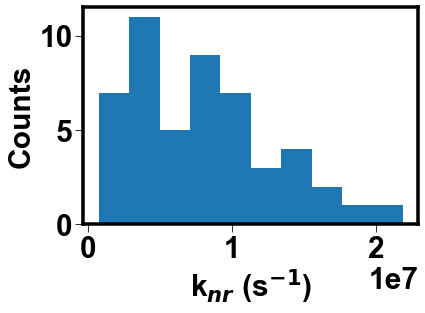

In [68]:
plt.figure()
plt.tick_params(length=8)
plt.hist(skew)
plt.xlabel("k$_{nr}$ (s$^{-1}$)", fontsize =30, fontweight ='bold')
#plt.xscale("log")
plt.ylabel('Counts', fontsize =30, fontweight ='bold')

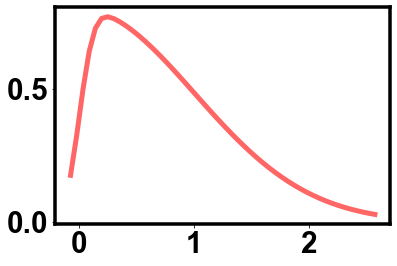

In [69]:
x = np.linspace(skewnorm.ppf(0.01, 10), skewnorm.ppf(0.99, 10), 50)
plt.plot(x, skewnorm.pdf(x, 10), 'r-', lw=5, alpha=0.6, label='skewnorm pdf')

Text(0, 0.5, 'Counts')

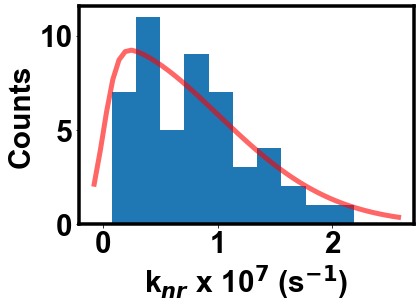

In [70]:
fig, ax = plt.subplots(1, 1)
ax.plot(x, skewnorm.pdf(x, 10)*12, 'r-', lw=5, alpha=0.6, label='skewnorm pdf')
ax.hist(skew*1e-7)
plt.xlabel("k$_{nr}$ x 10$^{7}$ (s$^{-1}$)", fontsize =30, fontweight ='bold')
#plt.xscale("log")
plt.ylabel('Counts', fontsize =30, fontweight ='bold')

## 1) Simulation of PL decays in HLI with a *skewed distribution* of K_nonrad from 10^6 to 10^7 cm-3 

In [71]:
# PL decay curves for each k1 value 
pl_skew = photoluminescence_HLI(k1= skew, t=np.linspace(0,5000, 5000)*1e-9)
pl_skew

# weight of each decay curve
skew_sum = pl_skew.sum(axis=0)
skew_sum.size


# weighted average curve which is most likely the one we end up seeing as overall decay
pl_skew_avg = np.average(pl_skew, weights=skew_sum, axis=-1)
pl_skew_avg.size

5000

<function matplotlib.pyplot.show(close=None, block=None)>

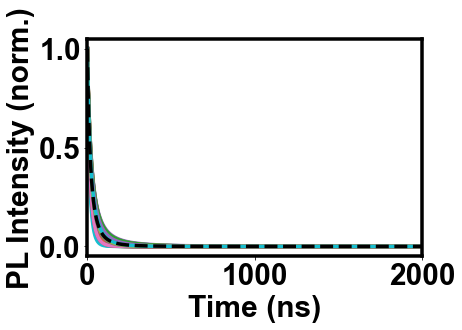

In [72]:
#plot of all exponetial decay for each k1 and average curve
plt.plot(t*1e9, pl_skew/np.max(pl_skew))
plt.plot(t*1e9, pl_skew_avg/np.max(pl_skew_avg),'k--', label="Average")
plt.xlabel('Time (ns)', fontsize =30, fontweight ='bold')
plt.ylabel('PL Intensity (norm.)', fontsize =30, fontweight ='bold')
plt.xlim(0, 2000)
plt.show

In [74]:
stretched_exp_skew = stretch_exp_fit(pl_skew_avg/np.max(pl_skew_avg), t)
print("tau_c (ns) = "+str(stretched_exp_skew[0]*1e9))
print("Beta = "+str(stretched_exp_skew[1]))
print("avg. tau (ns) = "+str(stretched_exp_skew[3]*1e9))

/Users/margheritataddei/Desktop/Documenti/U_Washington/Ginger_Lab/TRPL/GitHub/TimeResolvedPL/functions.py:39: RuntimeWarning: overflow encountered in true_divide
  Resid= (np.sum(((PL_sim-TRPL)**2)/(np.sqrt(PL_sim)**2)))


tau_c (ns) = 9.866134707806857
Beta = 0.5077084126077014
avg. tau (ns) = 19.19053752208147


In [76]:
double_exp_skew = double_exp_fit(pl_skew_avg/np.max(pl_skew_avg), t)
print("tau1 (ns) = "+str(double_exp_skew[0]*1e9))
print("a1 = "+str(double_exp_skew[1]))
print("tau2 (ns) = "+str(double_exp_skew[2]*1e9))
print("a2 = "+str(double_exp_skew[3]))
print("avg. tau (ns) = "+str(double_exp_skew[4]*1e9))

tau1 (ns) = 237.61123292290756
a1 = 0.016651807886099934
tau2 (ns) = 31.96620975950014
a2 = 0.7974126710926469
avg. tau (ns) = 36.17270876157616


In [77]:
#triple_exp_skew = triple_exp_fit(pl_skew_avg/np.max(pl_skew_avg), t)
#print("tau1 (ns) = "+str(triple_exp_skew[0]*1e9))
#print("a1 = "+str(triple_exp_skew[1]))
#print("tau2 (ns) = "+str(triple_exp_skew[2]*1e9))
#print("a2 = "+str(triple_exp_skew[3]))
#print("tau3 (ns) = "+str(triple_exp_skew[4]*1e9))
#print("a3 (ns) = "+str(triple_exp_skew[5]))
#print("avg. tau (ns) = "+str(triple_exp_skew[6]*1e9))

In [79]:
single_exp_skew = single_exp_fit(pl_skew_avg/np.max(pl_skew_avg), t)
print("tau (ns) = "+str(single_exp_skew[0]*1e9))
print("a = "+str(single_exp_skew[1]))
print("avg. tau (ns) = "+str(single_exp_skew[2]*1e9))

tau (ns) = 177.56680197485272
a = 0.2763727087170461
avg. tau (ns) = 177.56680197485272


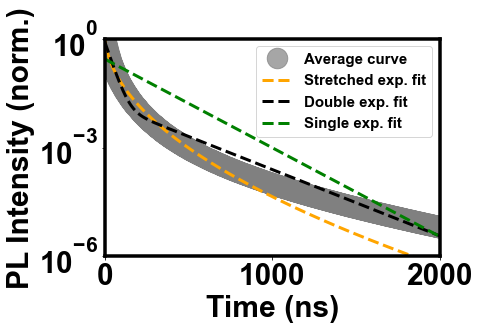

In [81]:
# plot average curve and multiple exponential fitting curves
#plt.figure(figsize=(10,8))
plt.plot(t*1e9, pl_skew_avg/np.max(pl_skew_avg),'C1o', color='grey', alpha=0.7,label="Average curve")
plt.plot(t*1e9, stretched_exp_skew[4], '--', color='orange', lw = 3, label="Stretched exp. fit")
plt.plot(t*1e9, double_exp_skew[5], 'k--', lw = 3, label="Double exp. fit")
#plt.plot(t*1e9, triple_exp_skew[7], 'c--', lw = 3, label="triple exp fit")
plt.plot(t*1e9, single_exp_skew[3], 'g--', lw = 3, label="Single exp. fit")
plt.yscale('log')
plt.xlim(0, 2000)
plt.ylim(0.000001, 1)
plt.xlabel("Time (ns)", fontsize =30, fontweight ='bold')
plt.ylabel("PL Intensity (norm.)", fontsize =30, fontweight ='bold')
plt.legend(fontsize=15)

In [82]:
#Mathematical deriation of lifetime from average curve knowing at $\tau$ : $I = \frac{I_0}{e}$

#photoluminescence maximum divided by e
PL_e_skew = np.max(pl_skew, axis=0)/np.e
PL_e_skew.size

# index of PL data calculated considering each array inside the array of pl singularly
time_skew_PL_e = np.array([])
for ix, i in enumerate(PL_e_skew):
    b = find_idx(pl_skew[ix, :], i)
    time_skew_PL_e = np.append(time_skew_PL_e, b)
time_skew_PL_e

# array of lifetime at which PL=PL0/e
lifetime_skew = np.array([])
for i in time_skew_PL_e:
    lifetime_skew = np.append(lifetime_skew, t[int(i)]) 
lifetime_skew*1e9

# index of LLI PL data calculated considering each array inside the array of pl singularly
time_skew_PL_e = np.array([])
for ix, i in enumerate(PL_e_skew):
    b = find_idx(pl_skew[:, ix], i)
    time_skew_PL_e = np.append(time_skew_PL_e, b)
time_skew_PL_e

# array of lifetime at which PL=PL0/e
lifetime_skew = np.array([])
for i in time_skew_PL_e:
    lifetime_skew = np.append(lifetime_skew, t[int(i)]) 
lifetime_skew*1e9


lifetime_skew_avg = np.average(lifetime_skew, weights= skew_sum, axis=-1)
lifetime_skew_avg*1e9

23.421188889827587

Text(0.5, 0, 't (ns)')

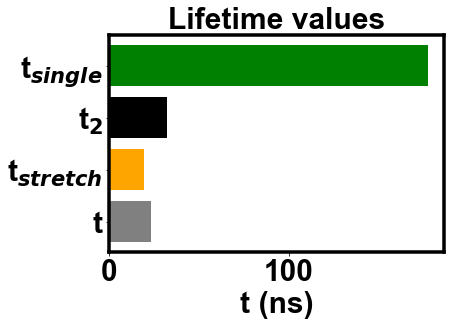

In [83]:
#plot of different tau values, from mathematical calculation (reference) and fitting functions
plt.figure()
plt.title("Lifetime values", fontsize=30, fontweight="bold")
plt.barh("t", lifetime_skew_avg*1e9, color='grey')
plt.barh("t$_{stretch}$", stretched_exp_skew[3]*1e9, color = 'orange')
#plt.barh("t$_{avg}$", double_exp_skew[4]*1e9, color= 'red')
plt.barh("t$_{2}$", double_exp_skew[2]*1e9, color='black')
plt.barh("t$_{single}$", single_exp_skew[2]*1e9, color= 'green')
plt.xlabel("t (ns)", fontsize =30 , fontweight='bold')
#plt.xlim(0, 600)
#plt.xlim(0,400, 20)

SRV1=0 theoretical value = 1756.739607533202 cm/s
SRV1=SRV2 theoretical value = 858.0070165232221 cm/s
SRV1=0 from stretched exp fitting = 2160.2731944443735 cm/s
SRV1=SRV2 from stretched exp fitting = 1049.5075672856085 cm/s
SRV1=0 from tau 2 of biexp fitting = 1274.9432359775783 cm/s
SRV1=SRV2 from tau 2 of biexp fitting = 626.6778229651057 cm/s
SRV1=0 from tau avg biexp fitting = 1123.0748665412664 cm/s
SRV1=SRV2 from tau avg biexp fitting = 553.1450229625688 cm/s
SRV1=0 from tau avg biexp fitting = 221.14474728500588 cm/s
SRV1=SRV2 from tau avg biexp fitting = 110.24301678622159 cm/s


Text(0.5, 0, '$SRV (cm/s)$')

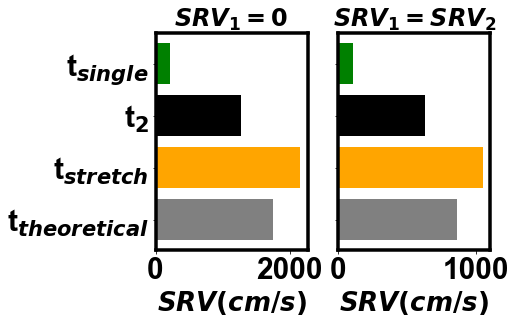

In [84]:
surf_lifetime_avg = calculate_surface_lifetime(lifetime_skew_avg*1e9)
SRV_avg = calculate_srv (surf_lifetime_avg)
print("SRV1=0 theoretical value = " +str(SRV_avg[0]) +' cm/s')
print("SRV1=SRV2 theoretical value = " +str(SRV_avg[1]) +' cm/s' )

surf_lifetime_stretch = calculate_surface_lifetime(stretched_exp_skew[3]*1e9)
SRV_avg_stretch = calculate_srv (surf_lifetime_stretch)
print("SRV1=0 from stretched exp fitting = " +str(SRV_avg_stretch[0]) +' cm/s')
print("SRV1=SRV2 from stretched exp fitting = " +str(SRV_avg_stretch[1]) +' cm/s' )

surf_lifetime_tau_2 = calculate_surface_lifetime(double_exp_skew[2]*1e9)
SRV_avg_tau2 = calculate_srv (surf_lifetime_tau_2)
print("SRV1=0 from tau 2 of biexp fitting = " +str(SRV_avg_tau2[0]) +' cm/s')
print("SRV1=SRV2 from tau 2 of biexp fitting = " +str(SRV_avg_tau2[1]) +' cm/s' )

surf_lifetime_bi = calculate_surface_lifetime(double_exp_skew[4]*1e9)
SRV_avg_bi = calculate_srv (surf_lifetime_bi)
print("SRV1=0 from tau avg biexp fitting = " +str(SRV_avg_bi[0]) +' cm/s')
print("SRV1=SRV2 from tau avg biexp fitting = " +str(SRV_avg_bi[1]) +' cm/s' )

surf_lifetime_mono = calculate_surface_lifetime(single_exp_skew[2]*1e9)
SRV_avg_mono = calculate_srv (surf_lifetime_mono)
print("SRV1=0 from tau avg biexp fitting = " +str(SRV_avg_mono[0]) +' cm/s')
print("SRV1=SRV2 from tau avg biexp fitting = " +str(SRV_avg_mono[1]) +' cm/s' )



fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)


ax1.barh("t$_{theoretical}$", SRV_avg[0], color='grey')
ax1.barh("t$_{stretch}$", SRV_avg_stretch[0], color='orange')
#ax1.barh("t$_{avg}$", SRV_avg_bi[0])
ax1.barh("t$_{2}$", SRV_avg_tau2[0], color='black')
ax1.barh("t$_{single}$", SRV_avg_mono[0], color='green')
ax1.set_title("$SRV_{1} = 0$")
ax1.set_xlabel("$SRV (cm/s)$", fontsize= 26)

ax2.barh("t$_{theoretical}$",SRV_avg[1], color='grey')
ax2.barh("t$_{stretch}$", SRV_avg_stretch[1], color='orange')
#ax2.barh("t$_{avg}$", SRV_avg_bi[1])
ax2.barh("t$_{2}$",SRV_avg_tau2[1], color='black')
ax2.barh("t$_{single}$", SRV_avg_mono[1], color='green')
ax2.set_title("$SRV_{1} = SRV_{2}$")
ax2.set_xlabel("$SRV (cm/s)$", fontsize=26)

## 4) Simulation of PL decays in HLI with a *skewed distribution* of K_nonrad from 10^6 to 10^7 cm-3 

In [85]:
# PL decay curves for each k1 value 
pl_skew = photoluminescence_LLI(k1= skew, t=np.linspace(0,5000, 5000)*1e-9)
pl_skew

# weight of each decay curve
skew_sum = pl_skew.sum(axis=0)
skew_sum.size


# weighted average curve which is most likely the one we end up seeing as overall decay
pl_skew_avg = np.average(pl_skew, weights=skew_sum, axis=-1)
pl_skew_avg.size

5000

(0.0, 2000.0)

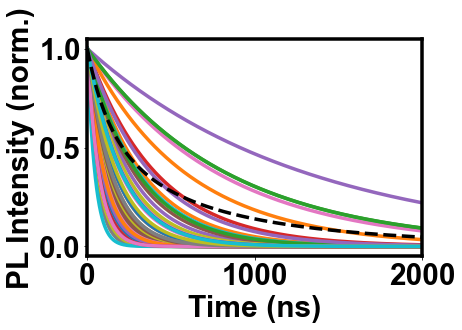

In [86]:
#plot of all exponetial decay for each k1 and average curve
plt.plot(t*1e9, pl_skew/np.max(pl_skew))
plt.plot(t*1e9, pl_skew_avg/np.max(pl_skew_avg),'k--', label="Average")
plt.xlabel('Time (ns)', fontsize= 30, fontweight ='bold' )
plt.ylabel('PL Intensity (norm.)', fontsize= 30, fontweight ='bold')
plt.xlim(0,2000)

In [89]:
stretched_exp_skew = stretch_exp_fit(pl_skew_avg/np.max(pl_skew_avg), t)
print("tau_c (ns) = "+str(stretched_exp_skew[0]*1e9))
print("Beta = "+str(stretched_exp_skew[1]))
print("avg. tau (ns) = "+str(stretched_exp_skew[3]*1e9))

tau_c (ns) = 318.16992783421443
Beta = 0.6289037468360235
avg. tau (ns) = 451.49373733063493


In [90]:
double_exp_skew = double_exp_fit(pl_skew_avg/np.max(pl_skew_avg), t)
print("tau1 (ns) = "+str(double_exp_skew[0]*1e9))
print("a1 = "+str(double_exp_skew[1]))
print("tau2 (ns) = "+str(double_exp_skew[2]*1e9))
print("a2 = "+str(double_exp_skew[3]))
print("avg. tau (ns) = "+str(double_exp_skew[4]*1e9))

tau1 (ns) = 225.28620931114028
a1 = 0.5977637522362333
tau2 (ns) = 1025.970373378589
a2 = 0.3432493574646883
avg. tau (ns) = 517.3483729675555


In [92]:
single_exp_skew = single_exp_fit(pl_skew_avg/np.max(pl_skew_avg), t)
print("tau (ns) = "+str(single_exp_skew[0]*1e9))
print("a = "+str(single_exp_skew[1]))
print("avg. tau (ns) = "+str(single_exp_skew[2]*1e9))

tau (ns) = 795.3101961044273
a = 0.625991966058715
avg. tau (ns) = 795.3101961044274


(0.04, 1)

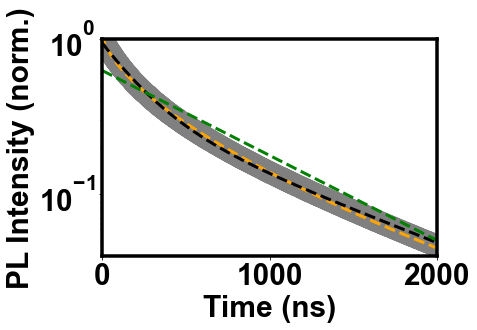

In [93]:
# plot average curve and multiple exponential fitting curves
plt.plot(t*1e9, pl_skew_avg/np.max(pl_skew_avg),'C1o', color='grey', alpha=0.7,label="Average curve")
plt.plot(t*1e9, stretched_exp_skew[4], '--', color='orange', lw = 3, label="Stretched exp. fit")
plt.plot(t*1e9, double_exp_skew[5], 'k--', lw = 3, label="Double exp. fit")
#plt.plot(t*1e9, triple_exp_skew[7], 'c--', lw = 3, label="triple exp fit")
plt.plot(t*1e9, single_exp_skew[3], 'g--', lw = 3, label="Single exp. fit")
plt.yscale('log')
plt.xlabel("Time (ns)", fontsize= 30, fontweight ='bold')
plt.ylabel("PL Intensity (norm.)", fontsize= 30, fontweight ='bold')
#plt.legend(fontsize=32, bbox_to_anchor= (1.05, 1))
plt.xlim(0, 2000)
plt.ylim(0.04, 1)

In [94]:
#Mathematical deriation of lifetime from average curve knowing at $\tau$ : $I = \frac{I_0}{e}$

#photoluminescence maximum divided by e
PL_e_skew = np.max(pl_skew, axis=0)/np.e
PL_e_skew.size

# index of PL data calculated considering each array inside the array of pl singularly
time_skew_PL_e = np.array([])
for ix, i in enumerate(PL_e_skew):
    b = find_idx(pl_skew[ix, :], i)
    time_skew_PL_e = np.append(time_skew_PL_e, b)
time_skew_PL_e

# array of lifetime at which PL=PL0/e
lifetime_skew = np.array([])
for i in time_skew_PL_e:
    lifetime_skew = np.append(lifetime_skew, t[int(i)]) 
lifetime_skew*1e9

# index of LLI PL data calculated considering each array inside the array of pl singularly
time_skew_PL_e = np.array([])
for ix, i in enumerate(PL_e_skew):
    b = find_idx(pl_skew[:, ix], i)
    time_skew_PL_e = np.append(time_skew_PL_e, b)
time_skew_PL_e

# array of lifetime at which PL=PL0/e
lifetime_skew = np.array([])
for i in time_skew_PL_e:
    lifetime_skew = np.append(lifetime_skew, t[int(i)]) 
lifetime_skew*1e9


lifetime_skew_avg = np.average(lifetime_skew, weights= skew_sum, axis=-1)
lifetime_skew_avg*1e9

486.6349709941369

(0.0, 1100.0)

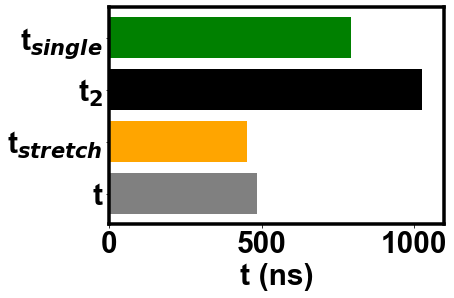

In [95]:
#plot of different tau values, from mathematical calculation (reference) and fitting functions
plt.figure()
#plt.title("Lifetime values", fontsize=30, fontweight="bold")
plt.barh("t", lifetime_skew_avg*1e9, color='grey')
plt.barh("t$_{stretch}$", stretched_exp_skew[3]*1e9, color = 'orange')
#plt.barh("t$_{avg}$", double_exp_skew[4]*1e9, color= 'red')
plt.barh("t$_{2}$", double_exp_skew[2]*1e9, color='black')
plt.barh("t$_{single}$", single_exp_skew[2]*1e9, color= 'green')
plt.xlabel("t (ns)", fontsize =30 , fontweight='bold')
plt.xlim(0, 1100)

SRV1=0 theoretical value = 77.30462820862697 cm/s
SRV1=SRV2 theoretical value = 38.611989819825276 cm/s
SRV1=0 from stretched exp fitting = 83.72086975121287 cm/s
SRV1=SRV2 from stretched exp fitting = 41.81314310900862 cm/s
SRV1=0 from tau 2 of biexp fitting = 34.00830061587277 cm/s
SRV1=SRV2 from tau 2 of biexp fitting = 16.996341596517713 cm/s
SRV1=0 from tau avg biexp fitting = 72.41166531204247 cm/s
SRV1=SRV2 from tau avg biexp fitting = 36.17044910401292 cm/s
SRV1=0 from tau avg biexp fitting = 45.33182652370793 cm/s
SRV1=SRV2 from tau avg biexp fitting = 22.65204092752317 cm/s


Text(0.5, 0, '$SRV (cm/s)$')

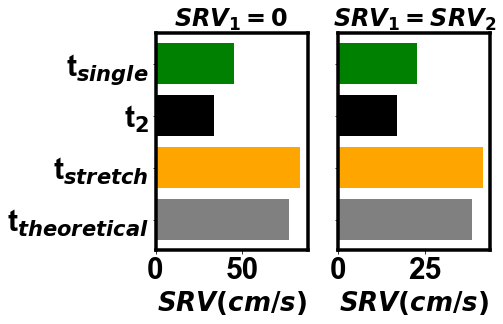

In [96]:
surf_lifetime_avg = calculate_surface_lifetime(lifetime_skew_avg*1e9)
SRV_avg = calculate_srv (surf_lifetime_avg)
print("SRV1=0 theoretical value = " +str(SRV_avg[0]) +' cm/s')
print("SRV1=SRV2 theoretical value = " +str(SRV_avg[1]) +' cm/s' )

surf_lifetime_stretch = calculate_surface_lifetime(stretched_exp_skew[3]*1e9)
SRV_avg_stretch = calculate_srv (surf_lifetime_stretch)
print("SRV1=0 from stretched exp fitting = " +str(SRV_avg_stretch[0]) +' cm/s')
print("SRV1=SRV2 from stretched exp fitting = " +str(SRV_avg_stretch[1]) +' cm/s' )

surf_lifetime_tau_2 = calculate_surface_lifetime(double_exp_skew[2]*1e9)
SRV_avg_tau2 = calculate_srv (surf_lifetime_tau_2)
print("SRV1=0 from tau 2 of biexp fitting = " +str(SRV_avg_tau2[0]) +' cm/s')
print("SRV1=SRV2 from tau 2 of biexp fitting = " +str(SRV_avg_tau2[1]) +' cm/s' )

surf_lifetime_bi = calculate_surface_lifetime(double_exp_skew[4]*1e9)
SRV_avg_bi = calculate_srv (surf_lifetime_bi)
print("SRV1=0 from tau avg biexp fitting = " +str(SRV_avg_bi[0]) +' cm/s')
print("SRV1=SRV2 from tau avg biexp fitting = " +str(SRV_avg_bi[1]) +' cm/s' )

surf_lifetime_mono = calculate_surface_lifetime(single_exp_skew[2]*1e9)
SRV_avg_mono = calculate_srv (surf_lifetime_mono)
print("SRV1=0 from tau avg biexp fitting = " +str(SRV_avg_mono[0]) +' cm/s')
print("SRV1=SRV2 from tau avg biexp fitting = " +str(SRV_avg_mono[1]) +' cm/s' )


fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)


ax1.barh("t$_{theoretical}$", SRV_avg[0], color='grey')
ax1.barh("t$_{stretch}$", SRV_avg_stretch[0], color='orange')
#ax1.barh("t$_{avg}$", SRV_avg_bi[0])
ax1.barh("t$_{2}$", SRV_avg_tau2[0], color='black')
ax1.barh("t$_{single}$", SRV_avg_mono[0], color='green')
ax1.set_title("$SRV_{1} = 0$")
ax1.set_xlabel("$SRV (cm/s)$", fontsize= 26)

ax2.barh("t$_{theoretical}$",SRV_avg[1], color='grey')
ax2.barh("t$_{stretch}$", SRV_avg_stretch[1], color='orange')
#ax2.barh("t$_{avg}$", SRV_avg_bi[1])
ax2.barh("t$_{2}$",SRV_avg_tau2[1], color='black')
ax2.barh("t$_{single}$", SRV_avg_mono[1], color='green')
ax2.set_title("$SRV_{1} = SRV_{2}$")
ax2.set_xlabel("$SRV (cm/s)$", fontsize=26)

## Gaussian distribution

In [97]:
 #g = np.random.normal(loc = 1e6, scale=1e5, size=50)

In [98]:
#g = np.absolute(gauss)

In [99]:
g = np.array([1031993.91473643, 1132375.34981278, 1035476.90224385,
       1152538.17653732,  917630.63142193, 1094370.89066439,
        961679.82066201, 1026167.14406566, 1063405.68478251,
       1080583.83750388, 1054543.19893835, 1126847.23950423,
        806766.31116755,  886997.29457306,  976979.40971966,
       1170040.773312  , 1004174.29235944,  958090.91535423,
       1045881.52284415,  884765.21388357, 1128716.33123089,
       1010249.50958783, 1102184.99214782, 1078083.40352149,
       1085872.81411233,  866339.55625633, 1174729.18159485,
       1083267.42426884, 1081508.21779547, 1096184.67784493,
       1061660.39664209,  965880.79754495,  949061.89626413,
       1035848.23940079,  875379.6533322 , 1075837.72417463,
       1039464.85935287, 1275808.04305661,  928450.44554653,
        966076.75085522,  947512.07256429, 1125204.80268722,
        871208.69875131, 1203221.20237626,  907305.89631062,
       1015794.42877552,  931860.78600798,  976054.85161622,
       1015790.00915211, 1004858.93430495])

Text(0, 0.5, 'Counts')

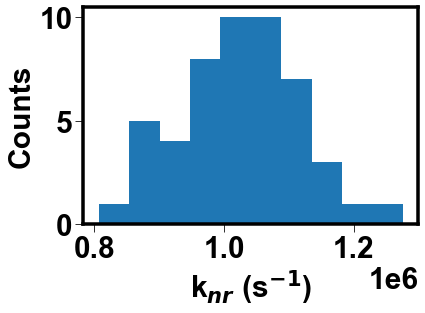

In [100]:
plt.figure()
plt.tick_params(length=8)
plt.hist(g)
plt.xlabel("k$_{nr}$ (s$^{-1}$)", fontsize =30, fontweight ='bold')
#plt.xscale("log")
plt.ylabel('Counts', fontsize =30, fontweight ='bold')

(800000.0, 1300000.0)

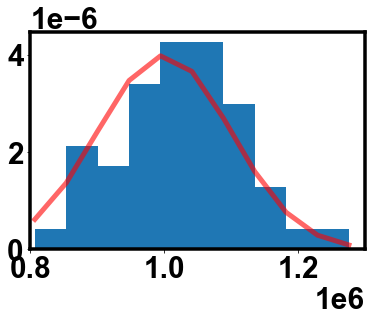

In [103]:
fig, ax = plt.subplots(1, 1)
bins=10
mu = 1e6
sigma = 1e5
count, bins, ignored = ax.hist(g, 10, density=True)
ax.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),'r-', lw=5, alpha=0.6)
plt.xlim(0.8e6, 1.3e6)

## 1) Simulation of PL decays in LLI with a *gaussian distribution* of K_nonrad around 10^6 cm-3 

In [104]:
#creation of LLI PL decay curves and average decay curve

# photoluminescence database from k1 from 1e5 to 1e7 and time from 0 to 1000ns
pl_LLI = photoluminescence_LLI(k1=g, t = np.linspace(0,5000, 5000)*1e-9)
pl_LLI

#weighted sum of photoluminescence data
pl_LLI_sum = pl_LLI.sum(axis=0)
pl_LLI_sum

#weighted average og the photoluminescence data
pl_LLI_avg = np.average(pl_LLI, weights=pl_LLI_sum, axis=-1)
pl_LLI_avg

array([2.00000000e+19, 1.99792678e+19, 1.99585577e+19, ...,
       1.36418657e+17, 1.36286130e+17, 1.36153733e+17])

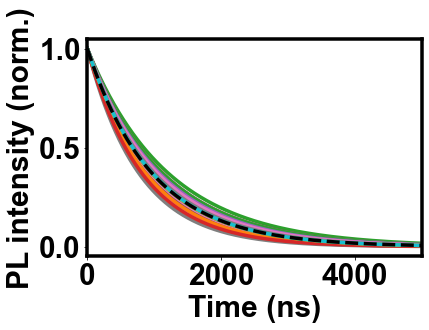

In [105]:
#plot of exponential decay of photoluminescence
plt.plot(t*1e9, pl_LLI/np.max(pl_LLI))
plt.plot(t*1e9, pl_LLI_avg/np.max(pl_LLI_avg),'k--', label="Average")
plt.xlabel('Time (ns)', fontsize =30, fontweight ='bold')
plt.ylabel('PL intensity (norm.)', fontsize= 30, fontweight ='bold')
plt.xlim(0, 5000)
plt.show()

In [109]:
#streched exponential fitting of the average PL exponential decay
stretched_exp = stretch_exp_fit(pl_LLI_avg/np.max(pl_LLI_avg), t)
print("tau_c (ns) = "+str(stretched_exp[0]*1e9))
print("Beta = "+str(stretched_exp[1]))
print("avg. tau (ns) = "+str(stretched_exp[3]*1e9))

tau_c (ns) = 970.2380059712403
Beta = 0.9824821723771685
avg. tau (ns) = 977.6794580994923


In [110]:
#double exponential fitting of the average PL exponential decay
double_exp = double_exp_fit(pl_LLI_avg/np.max(pl_LLI_avg), t)
print("tau1 (ns) = "+str(double_exp[0]*1e9))
print("a1 = "+str(double_exp[1]))
print("tau2 (ns) = "+str(double_exp[2]*1e9))
print("a2 = "+str(double_exp[3]))
print("avg. tau (ns) = "+str(double_exp[4]*1e9))

tau1 (ns) = 754.2086930847951
a1 = 0.198962156534781
tau2 (ns) = 1039.713107497508
a2 = 0.8006829732549872
avg. tau (ns) = 982.888368098538


In [111]:
#triple exponential fitting of the average PL exponential decay
#triple_exp = triple_exp_fit(pl_LLI_avg/np.max(pl_LLI_avg), t)
#print("tau1 (ns) = "+str(triple_exp[0]*1e9))
#print("a1 = "+str(triple_exp[1]))
#print("tau2 (ns) = "+str(triple_exp[2]*1e9))
#print("a2 = "+str(triple_exp[3]))
#print("tau3 (ns) = "+str(triple_exp[4]*1e9))
#print("a3 (ns) = "+str(triple_exp[5]))
#print("avg. tau (ns) = "+str(triple_exp[6]*1e9))

In [113]:
#single exponential fitting of the average PL exponential decay
single_exp = single_exp_fit(pl_LLI_avg/np.max(pl_LLI_avg), t)
print("tau (ns) = "+str(single_exp[0]*1e9))
print("a = "+str(single_exp[1]))
print("avg. tau (ns) = "+str(single_exp[2]*1e9))

tau (ns) = 992.7466357290418
a = 0.9890606142986131
avg. tau (ns) = 992.7466357290418


(0.1, 1)

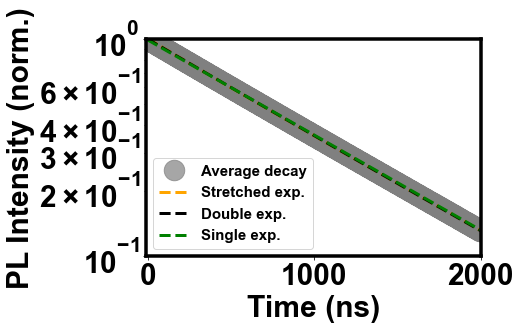

In [114]:
# plot fitting functions of the average PL exponential decay
#plt.figure(figsize=(10,8))
plt.plot(t*1e9, pl_LLI_avg/np.max(pl_LLI_avg),'C1o',color= 'grey', alpha=0.7,label="Average decay")
plt.plot(t*1e9, stretched_exp[4], '--',color='orange', lw = 3, label="Stretched exp.")
plt.plot(t*1e9, double_exp[5], 'k--', lw = 3, label="Double exp.")
#plt.plot(t*1e9, triple_exp[7], 'c--', lw = 3, label="triple exp fit")
plt.plot(t*1e9, single_exp[3], 'g--', lw = 3, label="Single exp.")
plt.yscale('log')
plt.xlabel("Time (ns)", fontsize=30, fontweight ='bold')
plt.ylabel("PL Intensity (norm.)", fontsize=30, fontweight ='bold')
plt.legend(fontsize=15)
plt.xlim(-10, 2000)
plt.ylim(0.1, 1)

In [115]:
#Mathematical derivation of theoretical average lifetime from weighted average of each time at which I = I0/e

#photoluminescence maximum from LLI regime divided by e
PL_e_LLI = np.max(pl_LLI, axis=0)/np.e
PL_e_LLI.size

# index of LLI PL data calculated considering each array inside the array of pl singularly
time_PL_LLI = np.array([])
for ix, i in enumerate(PL_e_LLI):
    b = find_idx(pl_LLI[:, ix], i)
    time_PL_LLI = np.append(time_PL_LLI, b)
time_PL_LLI

# array of lifetime at which PL=PL0/e at LLI
lifetime_LLI = np.array([])
for i in time_PL_LLI:
    lifetime_LLI = np.append(lifetime_LLI, t[int(i)]) 
lifetime_LLI*1e9

#weighted average of calculate lifetimes with pl_sum weights
avg_lifetime_LLI = np.average(lifetime_LLI, weights=pl_LLI_sum, axis=-1)
avg_lifetime_LLI*1e9

980.0226251912983

(0.0, 1100.0)

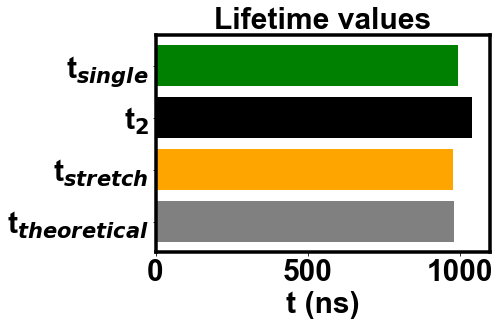

In [116]:
#plot of different tau values, from mathematical calculation (reference) and fitting functions
plt.figure()
plt.title("Lifetime values", fontsize=30, fontweight="bold")
plt.barh("t$_{theoretical}$", avg_lifetime_LLI*1e9, color='grey')
plt.barh("t$_{stretch}$", stretched_exp[3]*1e9, color = 'orange')
#plt.barh("t$_{avg}$", double_exp[4]*1e9, color= 'red')
plt.barh("t$_{2}$", double_exp[2]*1e9, color='black')
plt.barh("t$_{single}$", single_exp[2]*1e9, color= 'green')
plt.xlabel("t (ns)", fontsize =30 , fontweight='bold')
plt.xlim(0, 1100)
#plt.barh("Triple Exp $\tau^{3}$", triple_exp[4]*1e9)
#plt.barh("Triple Exp $\tau^{avg}$", triple_exp[6]*1e9)